https://www.kaggle.com/datasets/mssmartypants/water-quality

The dataset describes water quality based on the contamination of various elements.

All attributes are numeric variables and they are listed bellow:

aluminium - dangerous if greater than 2.8

ammonia - dangerous if greater than 32.5

arsenic - dangerous if greater than 0.01

barium - dangerous if greater than 2

cadmium - dangerous if greater than 0.005

chloramine - dangerous if greater than 4

chromium - dangerous if greater than 0.1

copper - dangerous if greater than 1.3

flouride - dangerous if greater than 1.5

bacteria - dangerous if greater than 0

viruses - dangerous if greater than 0

lead - dangerous if greater than 0.015

nitrates - dangerous if greater than 10

nitrites - dangerous if greater than 1

mercury - dangerous if greater than 0.002

perchlorate - dangerous if greater than 56

radium - dangerous if greater than 5

selenium - dangerous if greater than 0.5

silver - dangerous if greater than 0.1

uranium - dangerous if greater than 0.3

is_safe - class attribute {0 - not safe, 1 - safe}

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import shap
shap.initjs()
from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import train_test_validation

In [47]:
df = pd.read_csv('waterQuality1.csv')
df.head()

aluminium ammonia  arsenic  barium  cadmium  chloramine  chromium  copper  \
0       1.65    9.08     0.04    2.85    0.007        0.35      0.83    0.17   
1       2.32   21.16     0.01    3.31    0.002        5.28      0.68    0.66   
2       1.01   14.02     0.04    0.58    0.008        4.24      0.53    0.02   
3       1.36   11.33     0.04    2.96    0.001        7.23      0.03    1.66   
4       0.92   24.33     0.03    0.20    0.006        2.67      0.69    0.57   

   flouride  bacteria  ...   lead  nitrates  nitrites  mercury  perchlorate  \
0      0.05      0.20  ...  0.054     16.08      1.13    0.007        37.75   
1      0.90      0.65  ...  0.100      2.01      1.93    0.003        32.26   
2      0.99      0.05  ...  0.078     14.16      1.11    0.006        50.28   
3      1.08      0.71  ...  0.016      1.41      1.29    0.004         9.12   
4      0.61      0.13  ...  0.117      6.74      1.11    0.003        16.90   

   radium  selenium  silver  uranium  is_safe  
0    6.78      0.08    0.34     0.02     safe  
1    3.21      0.08    0.27     0.05        1  
2    7.07      0.07    0.44     0.01        0  
3    1.72      0.02    0.45     0.05        1  
4    2.41      0.02    0.06     0.02        1  

[5 rows x 21 columns]

In [48]:
print(df.shape)

(7999, 21)


In [49]:
print(df.describe())

         aluminium      arsenic       barium      cadmium   chloramine  \
count  7999.000000  7999.000000  7999.000000  7998.000000  7999.000000   
mean      0.666158     0.161445     1.567715     0.042811     2.176831   
std       1.265145     0.252590     1.216091     0.036049     2.567027   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.040000     0.030000     0.560000     0.008000     0.100000   
50%       0.070000     0.050000     1.190000     0.040000     0.530000   
75%       0.280000     0.100000     2.480000     0.070000     4.240000   
max       5.050000     1.050000     4.940000     0.130000     8.680000   

          chromium       copper     flouride     bacteria      viruses  \
count  7999.000000  7999.000000  7999.000000  7999.000000  7999.000000   
mean      0.247226     0.805622     0.771565     0.319665     0.328583   
std       0.270640     0.653829     0.435373     0.329485     0.378096   
min       0.000000    -0.940000     0

The variables nitrites and copper take negative values which is impossible. They have been replaced by the average value of the remaining data.

In [50]:
df.loc[df['copper']<0, 'copper'] = round(df[df['copper']>0]['copper'].mean(),2)
df.loc[df['nitrites']<0, 'nitrites'] = round(df[df['nitrites']>0]['nitrites'].mean(),2)

In [51]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7998 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7998 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

Columns "ammonia" and "is_safe" should have type "float64" since they take only numeric values. Non-numerical values need to be found. In the case of the "ammonia" column, they are changed to NaN and deleted. For the "is_safe" column, the labels are adjusted accordingly to the logic "0" - "unsafe", and "1" - "safe".

In [52]:
df['ammonia'] = pd.to_numeric(df['ammonia'], errors='coerce')
print(df[df['ammonia'].isnull()])

      aluminium  ammonia  arsenic  barium  cadmium  chloramine  chromium  \
7551       0.03      NaN     0.08    0.79     0.07        0.08      0.05   
7568       0.06      NaN     0.07    1.72     0.08        0.32      0.01   
7890       0.01      NaN     0.08    0.49     0.00        0.07      0.09   

      copper  flouride  bacteria  ...   lead  nitrates  nitrites  mercury  \
7551    0.58      0.34      0.00  ...  0.183      4.37      1.43    0.007   
7568    1.11      0.61      0.00  ...  0.178     12.10      2.03    0.008   
7890    0.06      0.72      0.57  ...  0.088      9.57      1.45    0.009   

      perchlorate  radium  selenium  silver  uranium  is_safe  
7551         0.62    2.54      0.07    0.05     0.05    #NUM!  
7568         1.37    2.05      0.06    0.10     0.07    #NUM!  
7890         7.67    7.70      0.03    0.05     0.02    #NUM!  

[3 rows x 21 columns]


In [53]:
df.isnull().values.any()

True

In [54]:
df = df.dropna(axis=0)
df.isnull().values.any()

False

In [55]:
print(df['is_safe'].unique())

['safe' '1' '0' 'unsafe']


In [56]:
is_safe_dictionary = {'safe' : 1, 'unsafe' : 0, '0' : 0, '1': 1}
df['is_safe'] = df['is_safe'].map(is_safe_dictionary)

<Axes: >

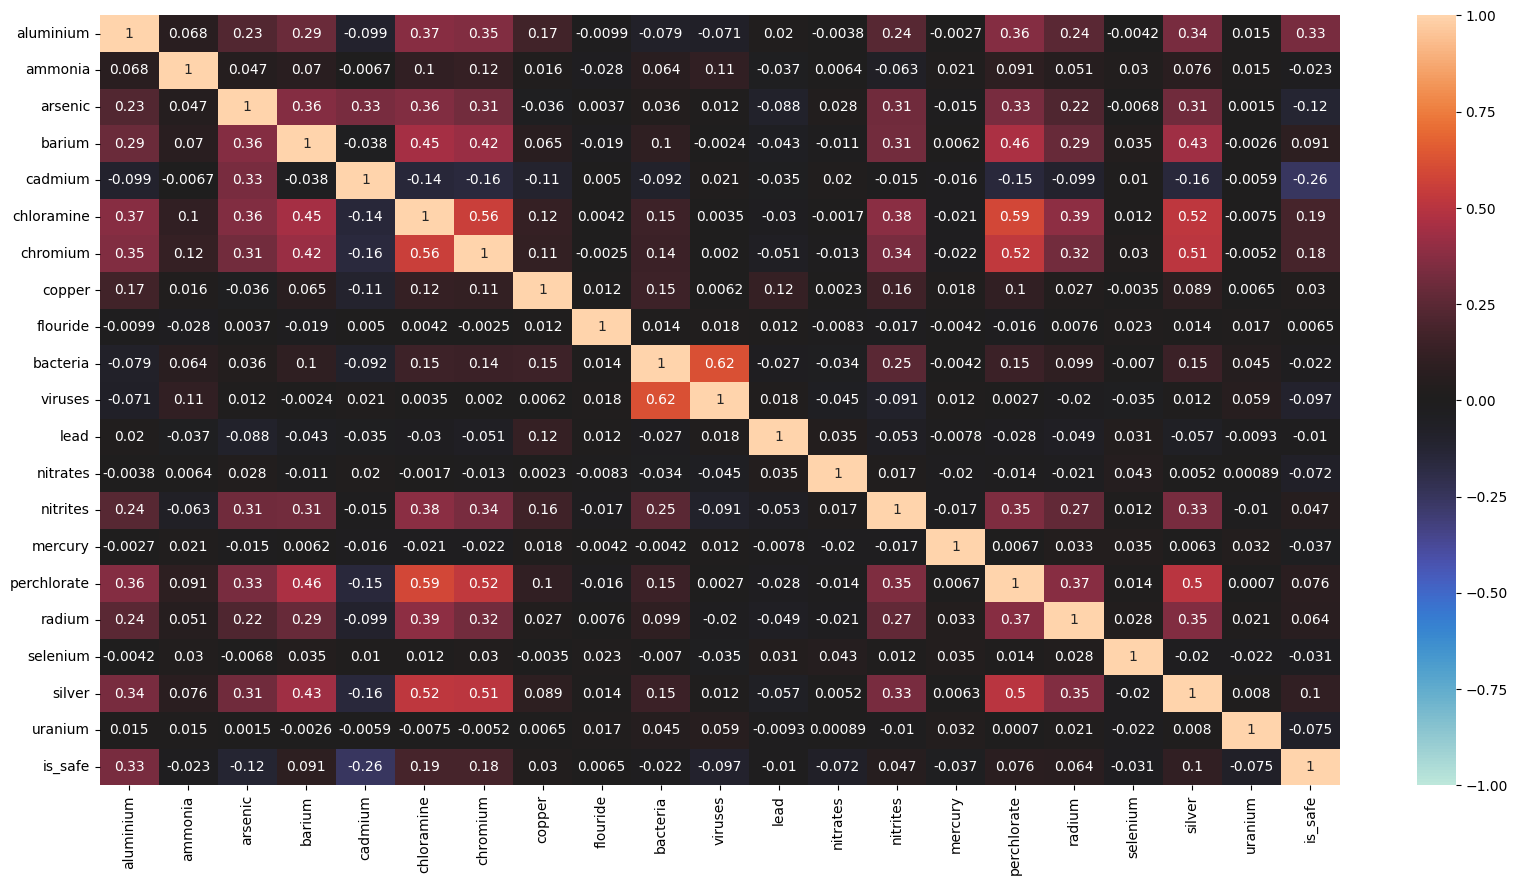

In [57]:
plt.figure(figsize=(20,10))
corr = df.corr()
sns.heatmap(corr, vmin=-1, center=0, vmax=1, annot=True)

In [58]:
df['pathogens'] = (df['bacteria']+df['viruses'])/2
df = df.drop(['bacteria', 'viruses'], axis=1)
df.head()

aluminium  ammonia  arsenic  barium  cadmium  chloramine  chromium  copper  \
0       1.65     9.08     0.04    2.85    0.007        0.35      0.83    0.17   
1       2.32    21.16     0.01    3.31    0.002        5.28      0.68    0.66   
2       1.01    14.02     0.04    0.58    0.008        4.24      0.53    0.02   
3       1.36    11.33     0.04    2.96    0.001        7.23      0.03    1.66   
4       0.92    24.33     0.03    0.20    0.006        2.67      0.69    0.57   

   flouride   lead  nitrates  nitrites  mercury  perchlorate  radium  \
0      0.05  0.054     16.08      1.13    0.007        37.75    6.78   
1      0.90  0.100      2.01      1.93    0.003        32.26    3.21   
2      0.99  0.078     14.16      1.11    0.006        50.28    7.07   
3      1.08  0.016      1.41      1.29    0.004         9.12    1.72   
4      0.61  0.117      6.74      1.11    0.003        16.90    2.41   

   selenium  silver  uranium  is_safe  pathogens  
0      0.08    0.34     0.02        1     0.1000  
1      0.08    0.27     0.05        1     0.6500  
2      0.07    0.44     0.01        0     0.0265  
3      0.02    0.45     0.05        1     0.7100  
4      0.02    0.06     0.02        1     0.0655

Variables 'bacteria' and 'viruses' are strongly correlated. Since they are both dangerous for water if greater than 0, the new columns 'pathogens' was created, which is the mean value of these two columns. 

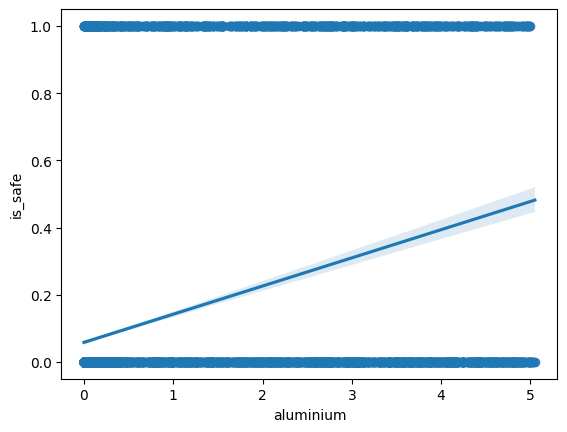

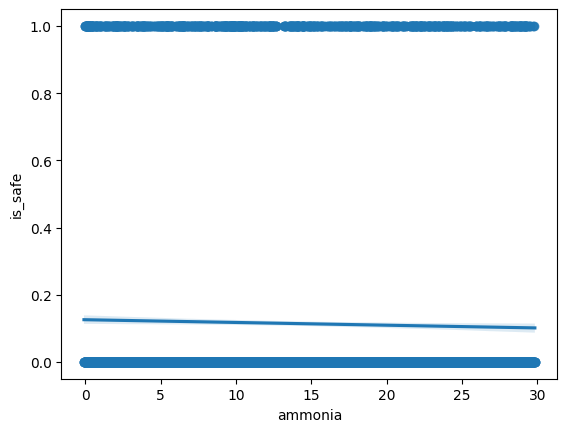

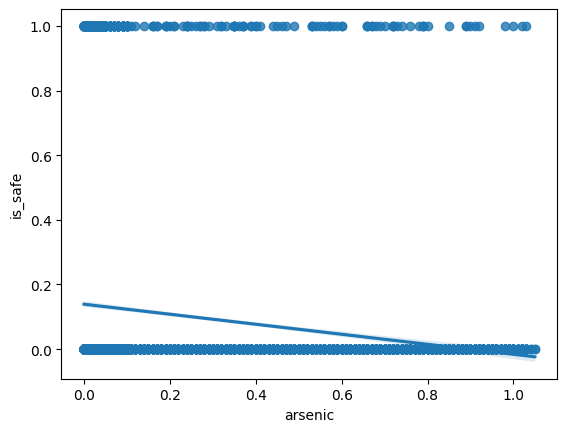

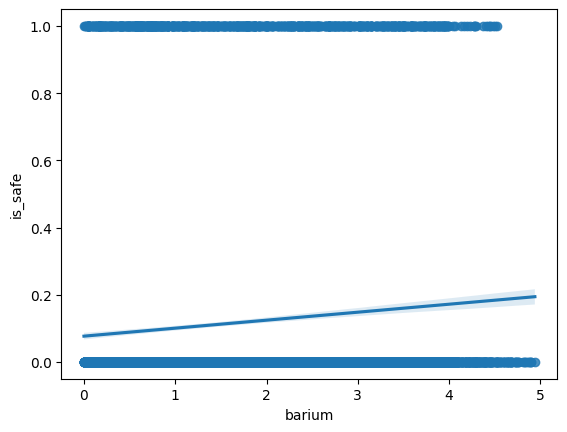

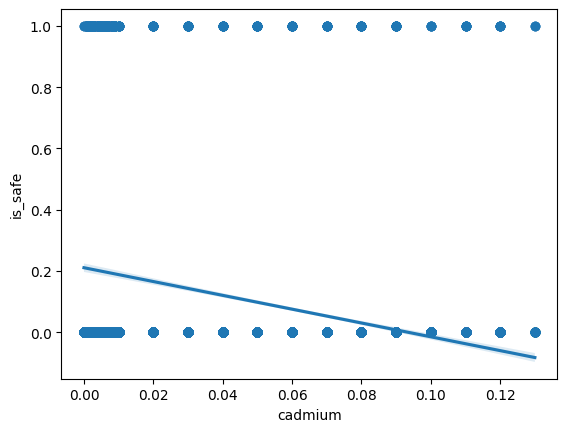

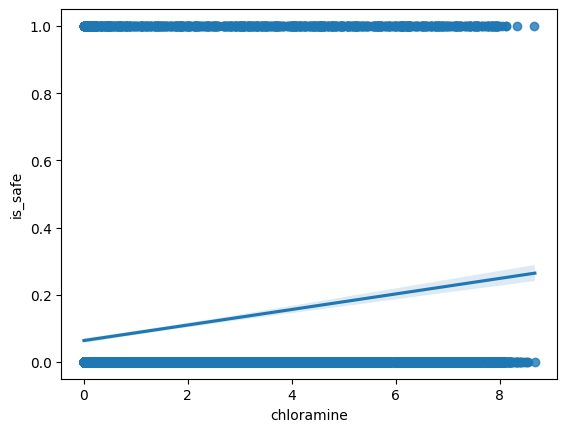

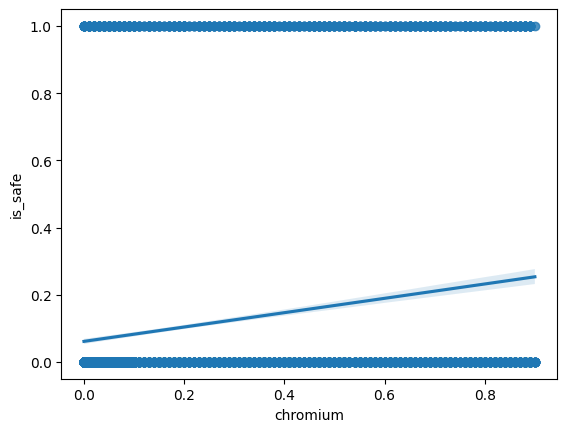

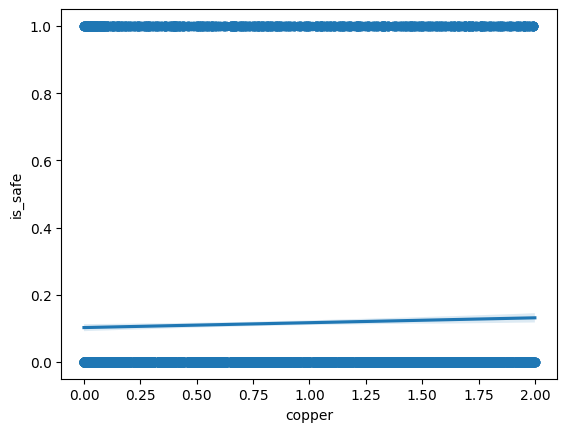

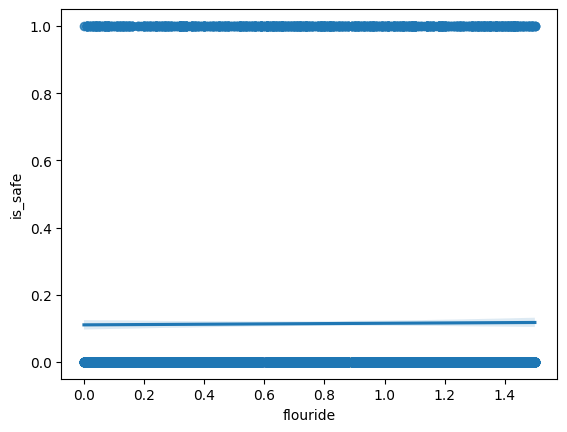

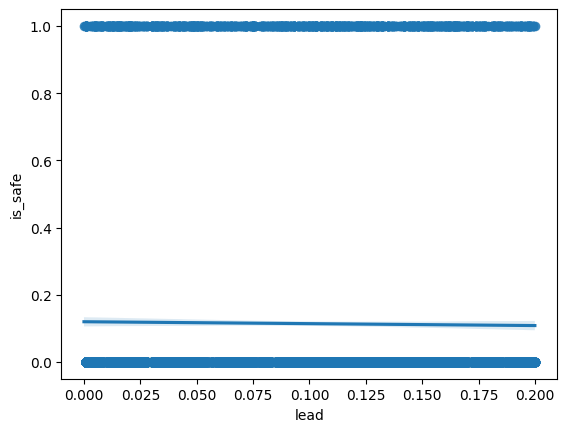

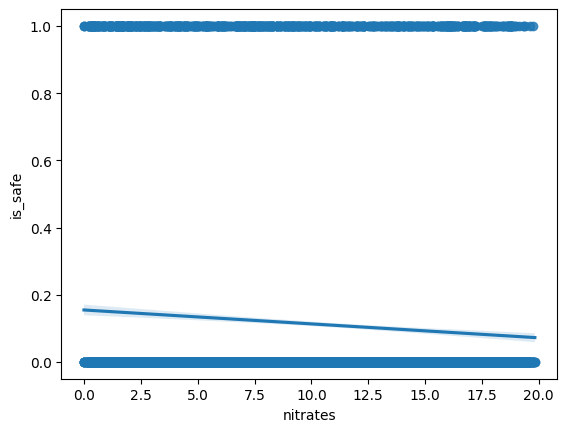

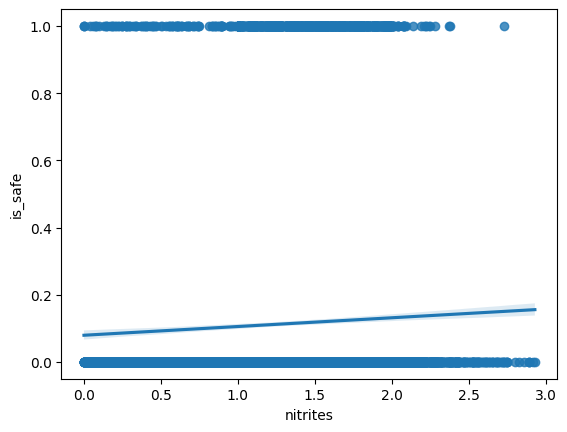

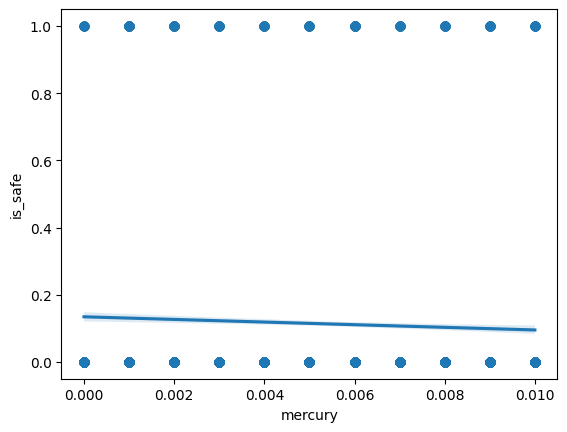

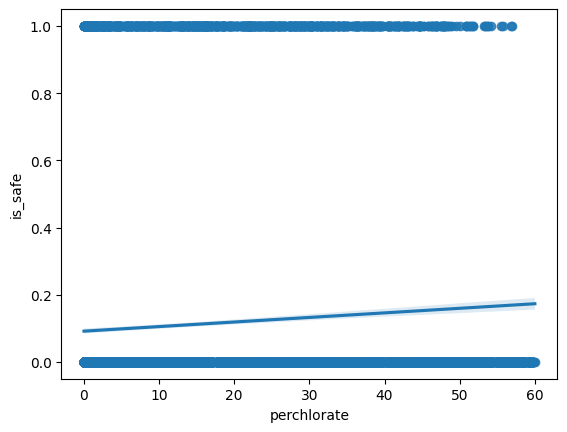

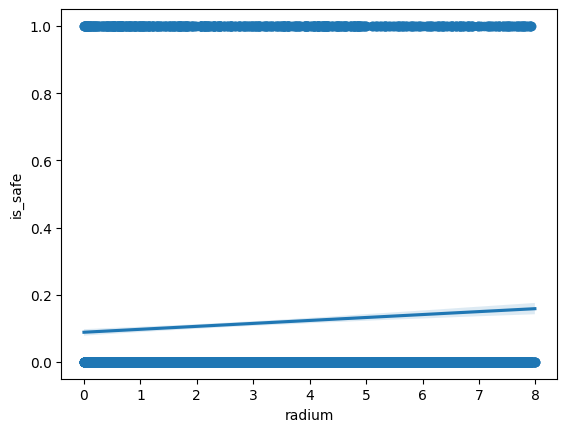

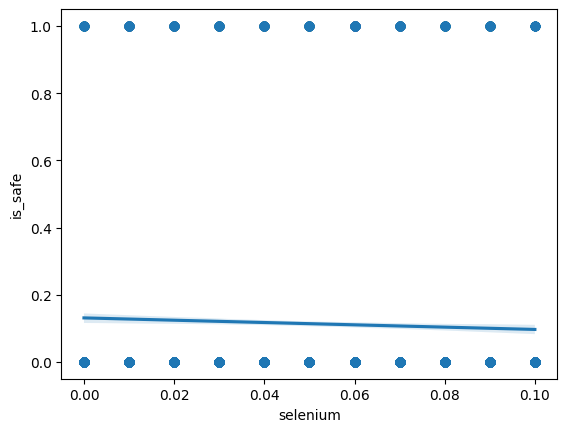

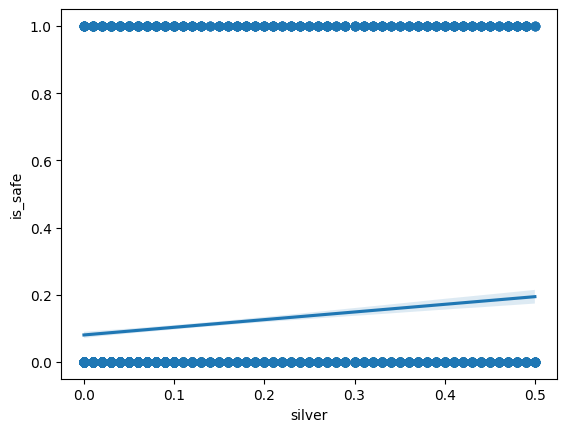

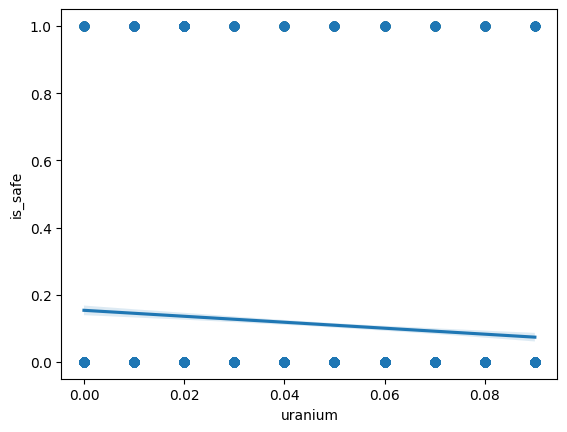

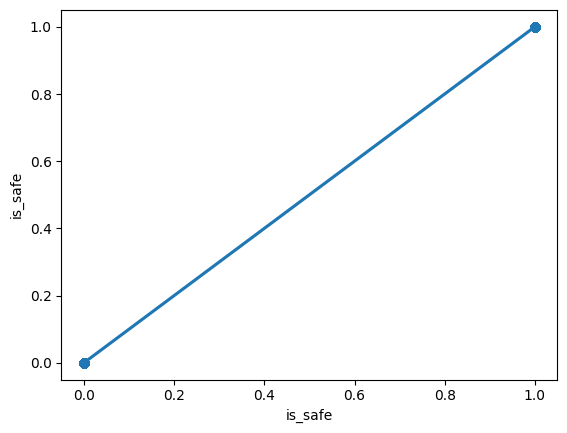

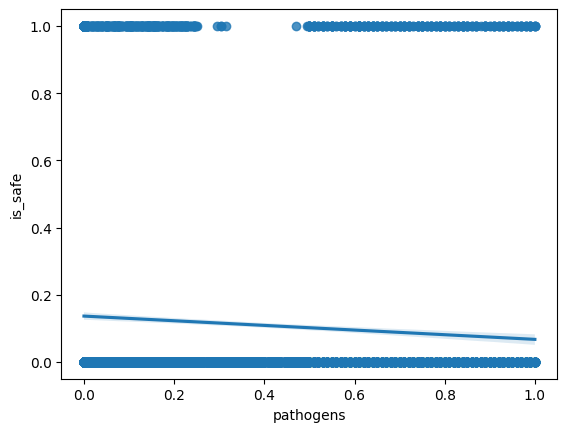

In [59]:
for var in df.columns:
    plt.figure() 
    sns.regplot(x=var, y='is_safe', data=df)

For some variables, such as perchlorate, nitrites or barium, observations marked '1' (safe) become less dense as the value of the variable increases. However, most variables show a similar division between the labels of the dependent variable.

In [60]:
X = df.drop('is_safe', axis=1)
y = df['is_safe']
X.head()

aluminium  ammonia  arsenic  barium  cadmium  chloramine  chromium  copper  \
0       1.65     9.08     0.04    2.85    0.007        0.35      0.83    0.17   
1       2.32    21.16     0.01    3.31    0.002        5.28      0.68    0.66   
2       1.01    14.02     0.04    0.58    0.008        4.24      0.53    0.02   
3       1.36    11.33     0.04    2.96    0.001        7.23      0.03    1.66   
4       0.92    24.33     0.03    0.20    0.006        2.67      0.69    0.57   

   flouride   lead  nitrates  nitrites  mercury  perchlorate  radium  \
0      0.05  0.054     16.08      1.13    0.007        37.75    6.78   
1      0.90  0.100      2.01      1.93    0.003        32.26    3.21   
2      0.99  0.078     14.16      1.11    0.006        50.28    7.07   
3      1.08  0.016      1.41      1.29    0.004         9.12    1.72   
4      0.61  0.117      6.74      1.11    0.003        16.90    2.41   

   selenium  silver  uranium  pathogens  
0      0.08    0.34     0.02     0.1000  
1      0.08    0.27     0.05     0.6500  
2      0.07    0.44     0.01     0.0265  
3      0.02    0.45     0.05     0.7100  
4      0.02    0.06     0.02     0.0655

In [61]:
pipe = Pipeline([('scaler', StandardScaler()), ('reducer', PCA(n_components=0.9))])
pipe.fit(X)
print(len(pipe['reducer'].components_))

15


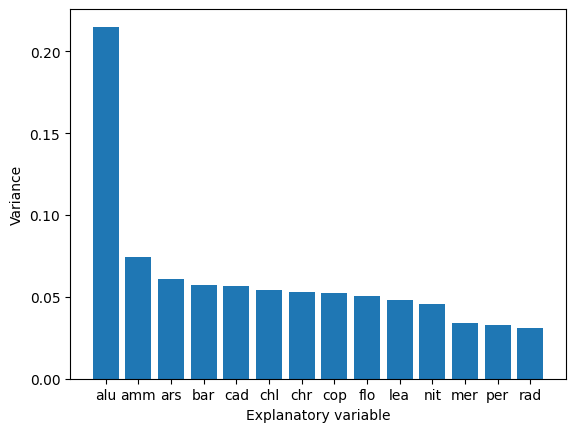

In [62]:
pipe = Pipeline([('scaler', StandardScaler()), ('reducer', PCA(n_components=15))])
pipe.fit(X)
columns = [word[:3] for word in X.iloc[:,:15].columns]
plt.bar(columns, pipe['reducer'].explained_variance_ratio_)
plt.xlabel('Explanatory variable')
plt.ylabel('Variance')
plt.show()

From PCA can be observed that there is no need to include so many variables to explain the 'is_safe' variable. 90% of the variance can be explained only with 15 variables. The correlation matrix also emphasizes that there are strong correlations between elements, so some of them could be dropped. However, all 19 attributes make the water dangerous to consume from a different level. Therefore, each one of them must be measured and included in the analysis to determine if water is safe or not.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [64]:
model_NB = GaussianNB()
model_NB.fit(X_train, y_train)
preds_NB = model_NB.predict(X_test)
accuracy = accuracy_score(y_test, preds_NB).round(2)
precision = precision_score(y_test, preds_NB).round(2)
recall = recall_score(y_test, preds_NB).round(2)
roc = roc_auc_score(y_test, preds_NB).round(2)
f1 = f1_score(y_test, preds_NB).round(2)
print('accuracy: {}, precision: {}, recall: {}, roc: {}, f1: {}'.format(accuracy, precision, recall, roc, f1))


accuracy: 0.85, precision: 0.41, recall: 0.67, roc: 0.77, f1: 0.51


In [65]:
print(confusion_matrix(y_test, preds_NB))

[[1559  217]
 [  74  149]]


There is no need to tune hiperparameters of GaussianNB model. It is only useful when the class distribution of dependent variable is known.

In [66]:
params_DT = {'criterion': ['gini', 'entropy'], 'splitter':['random', 'best'], 
              'max_depth':[None, 3, 5, 8, 10]}
grid_search_DT = GridSearchCV(DecisionTreeClassifier(), params_DT)
grid_search_DT.fit(X_train, y_train)
print(grid_search_DT.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'splitter': 'best'}


In [67]:
model_DT = DecisionTreeClassifier(criterion='entropy', max_depth=8)
model_DT.fit(X_train, y_train)
preds_DT = model_DT.predict(X_test)
accuracy = accuracy_score(y_test, preds_DT).round(2)
precision = precision_score(y_test, preds_DT).round(2)
recall = recall_score(y_test, preds_DT).round(2)
roc = roc_auc_score(y_test, preds_DT).round(2)
f1 = f1_score(y_test, preds_DT).round(2)
print('accuracy: {}, precision: {}, recall: {}, roc: {}, f1: {}'.format(accuracy, precision, recall, roc, f1))

accuracy: 0.96, precision: 0.88, recall: 0.79, roc: 0.89, f1: 0.83


In [68]:
print(confusion_matrix(y_test, preds_DT))

[[1752   24]
 [  47  176]]


In [69]:
params_RFC = {'n_estimators': [10,50,100,150,200,250,300,350], 'bootstrap':[True, False], 
              'max_depth':[2,3,5,8,10,12]}
grid_search_RFC = GridSearchCV(RandomForestClassifier(), params_RFC)
grid_search_RFC.fit(X_train, y_train)
print(grid_search_RFC.best_params_)

{'bootstrap': False, 'max_depth': 12, 'n_estimators': 350}


In [70]:
model_RFC = RandomForestClassifier(bootstrap=False, max_depth=12, n_estimators=350)
model_RFC.fit(X_train, y_train)
preds_RFC = model_RFC.predict(X_test)
accuracy = accuracy_score(y_test, preds_RFC).round(2)
precision = precision_score(y_test, preds_RFC).round(2)
recall = recall_score(y_test, preds_RFC).round(2)
roc = roc_auc_score(y_test, preds_RFC).round(2)
f1 = f1_score(y_test, preds_RFC).round(2)
print('accuracy: {}, precision: {}, recall: {}, roc: {}, f1: {}'.format(accuracy, precision, recall, roc, f1))

accuracy: 0.97, precision: 0.94, recall: 0.8, roc: 0.9, f1: 0.86


In [71]:
print(confusion_matrix(y_test, preds_RFC))

[[1765   11]
 [  45  178]]


In [98]:
params_GBC = {'n_estimators': [50,100,150,200,250], 'learning_rate':[0.001, 0.01, 0.1, 1], 
              'max_depth':[3,5,8,10]}
grid_search_GBC = GridSearchCV(GradientBoostingClassifier(), params_GBC)
grid_search_GBC.fit(X_train, y_train)
print(grid_search_GBC.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [99]:
model_GBC = GradientBoostingClassifier(max_depth=8, n_estimators=250)
model_GBC.fit(X_train.values, y_train)
preds_GBC = model_GBC.predict(X_test)
accuracy = accuracy_score(y_test, preds_GBC).round(2)
precision = precision_score(y_test, preds_GBC).round(2)
recall = recall_score(y_test, preds_GBC).round(2)
roc = roc_auc_score(y_test, preds_GBC).round(2)
f1 = f1_score(y_test, preds_GBC).round(2)
print('accuracy: {}, precision: {}, recall: {}, roc: {}, f1: {}'.format(accuracy, precision, recall, roc, f1))

accuracy: 0.97, precision: 0.92, recall: 0.82, roc: 0.91, f1: 0.87


c:\Users\asias\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning:

X has feature names, but GradientBoostingClassifier was fitted without feature names



In [74]:
print(confusion_matrix(y_test, preds_GBC))

[[1763   13]
 [  38  185]]


From the analysis, can be concluded that DecisionTreeClassifier, RandomForestClassifier and GradientBoostingClassifier gave satisfying results. However, the last one presents the best measures. In the process of selecting the best model particularly important was precision. This measure is important while analysing "waterQuality" dataset, since it detects false positive cases (the higher precision, the least false positive cases). For instance, in the GuassianNB model precision equals 40%, which means that 60% of the observations tagged as safe water (positive) were indeed dangerous water (negative).  Marking dangerous water as safe can have horrific consequences. For subsequent shap analysis RandomForestClassifier was chosen since GradientBoostingClassifier is not supported model type in library shap.

In [75]:
explainer = shap.TreeExplainer(model_RFC)
shap_values =explainer.shap_values(X_test)

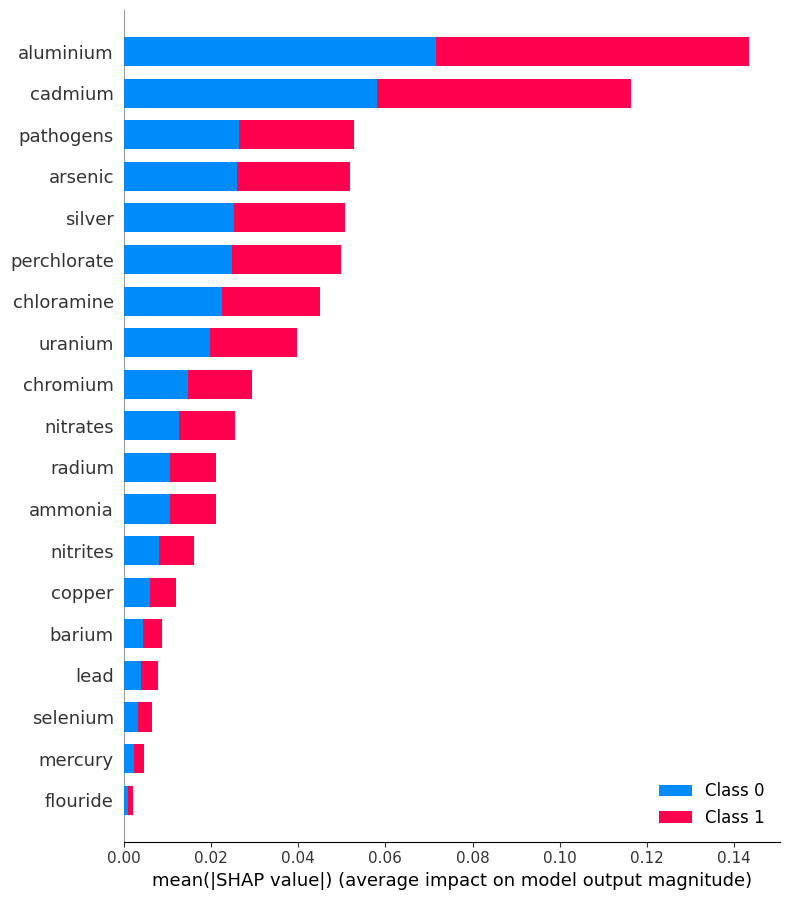

In [76]:
shap.summary_plot(shap_values, X_test)

We can observe that the red and blue colors occupy half of the bars for each class. This means that each feature has an equal impact on the classification of both safe water (label=1) and dangerous water (label=0) cases. The most predictive power have aluminium and cadmium. They significantly stand out from the rest of the features. However, arsenic, silver, pathogens, perchlorate and chloramine also have crucial impact on the model output.

c:\Users\asias\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\plots\_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



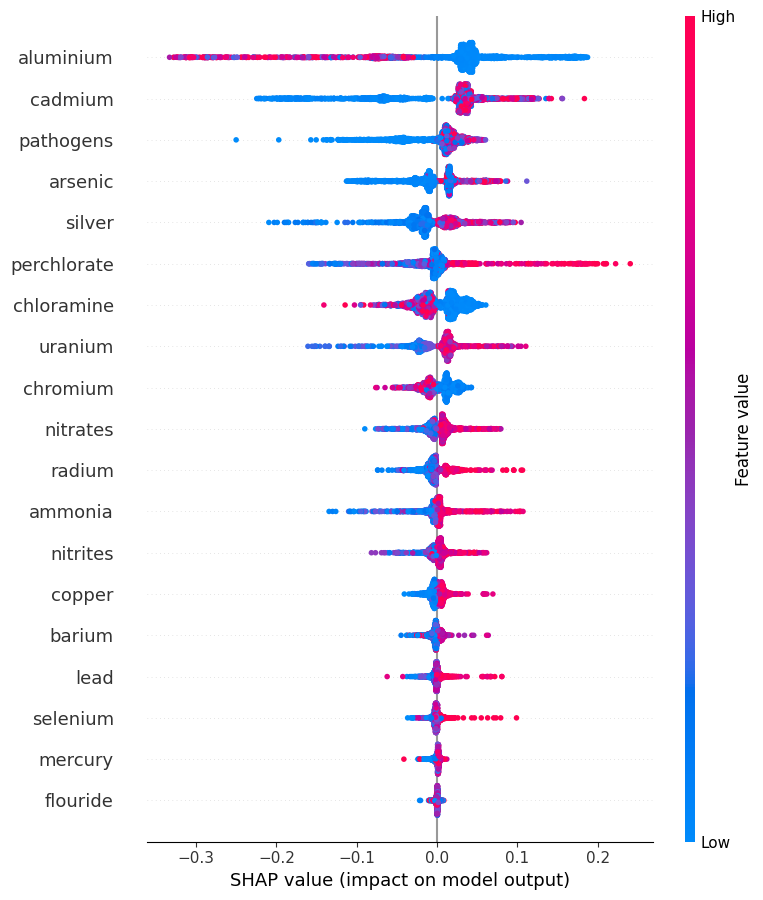

In [77]:
shap.summary_plot(shap_values[0], X_test)

The summary plot shows the impact of individual contaminants on water safety. For most variables, the higher the value of a variable, the more likely it is that the water is unsafe for health. However, aluminium, chromium and chloramine show an inverse relationship, which does not follow common logic.

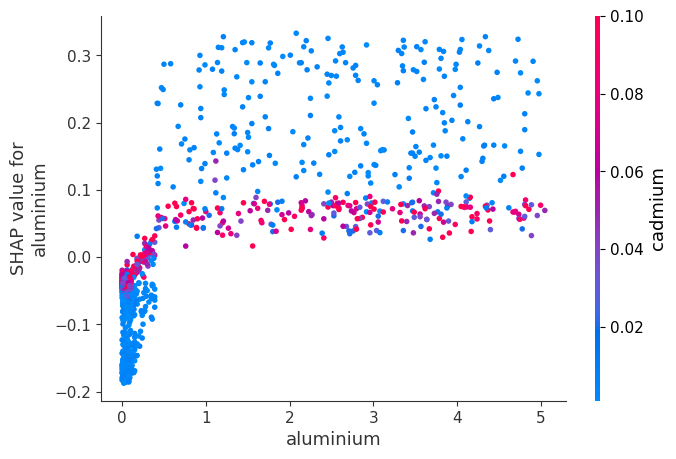

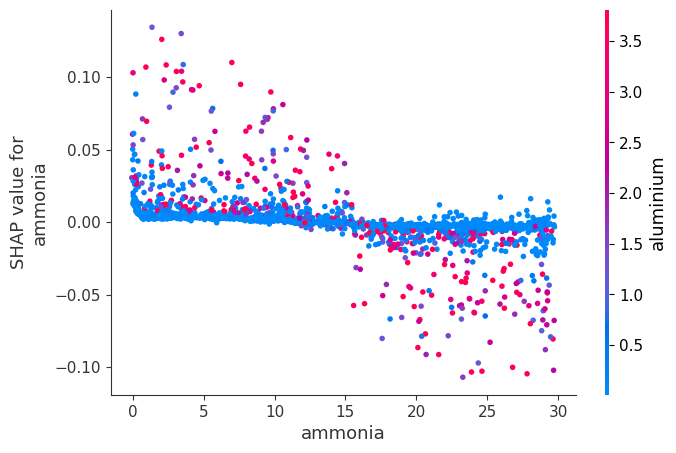

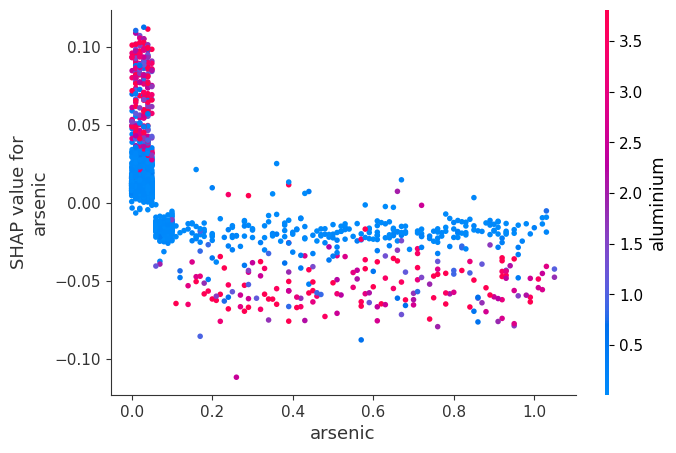

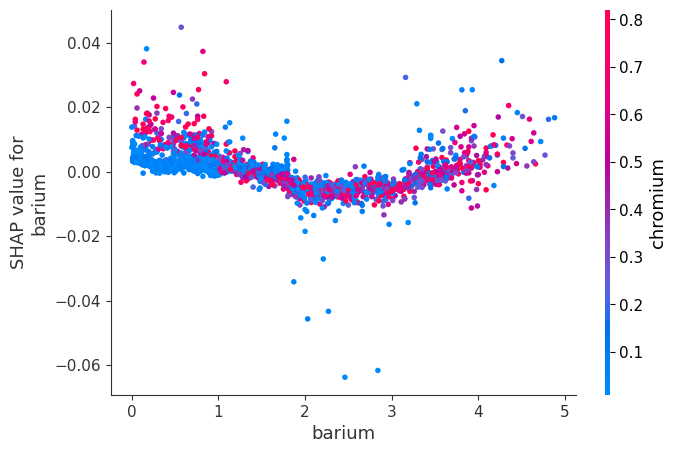

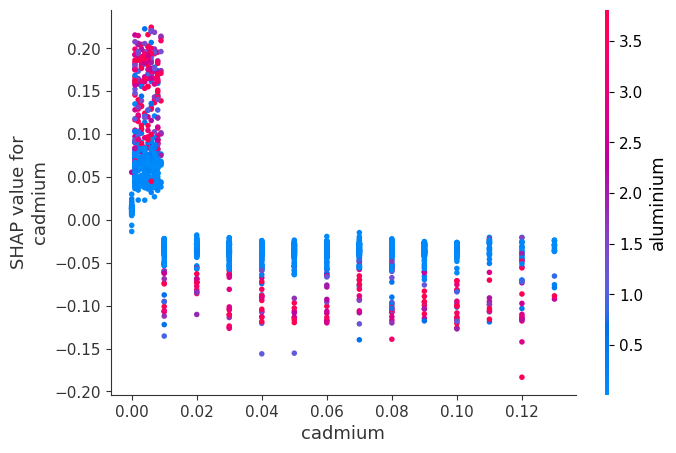

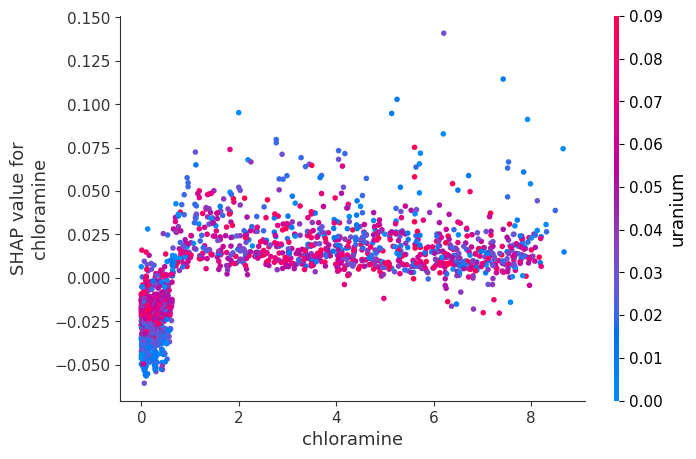

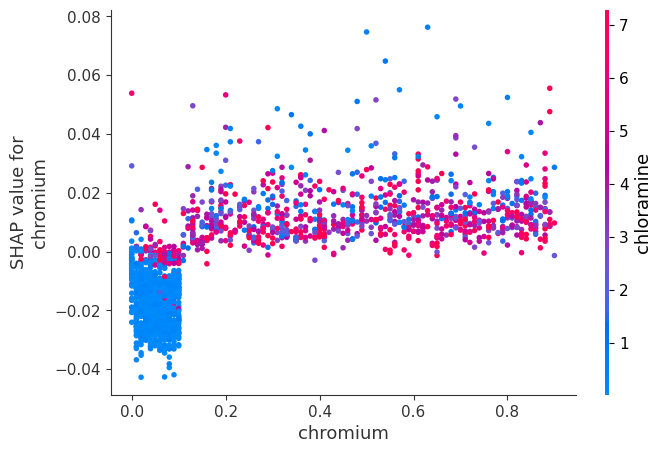

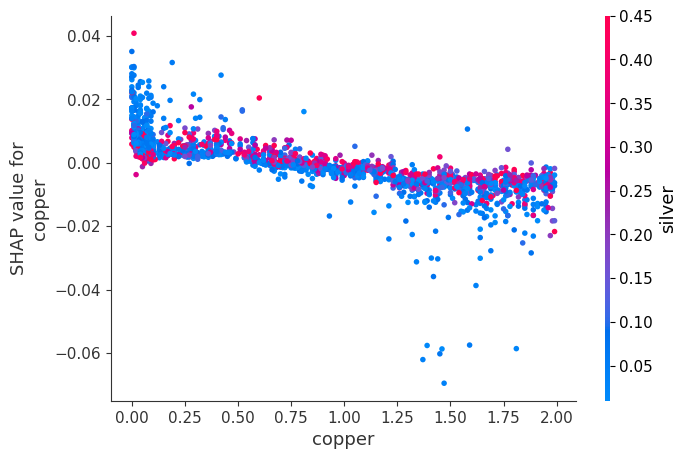

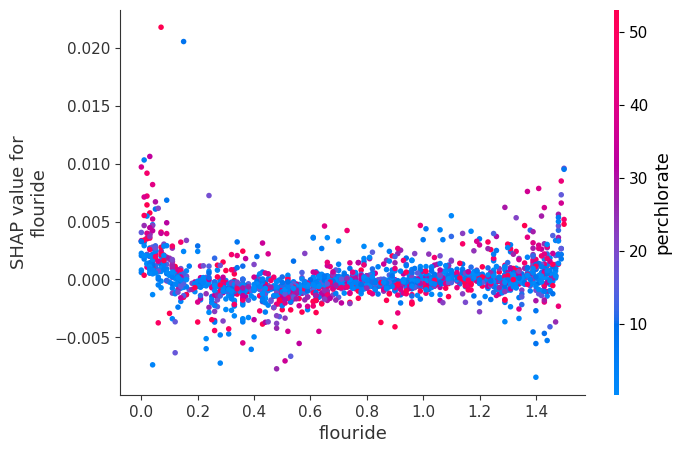

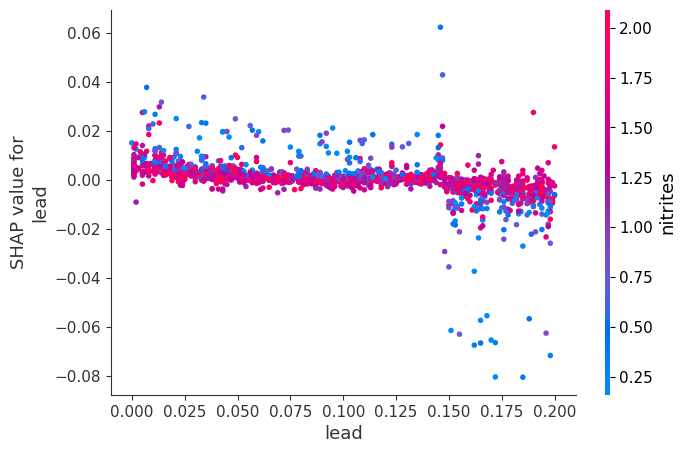

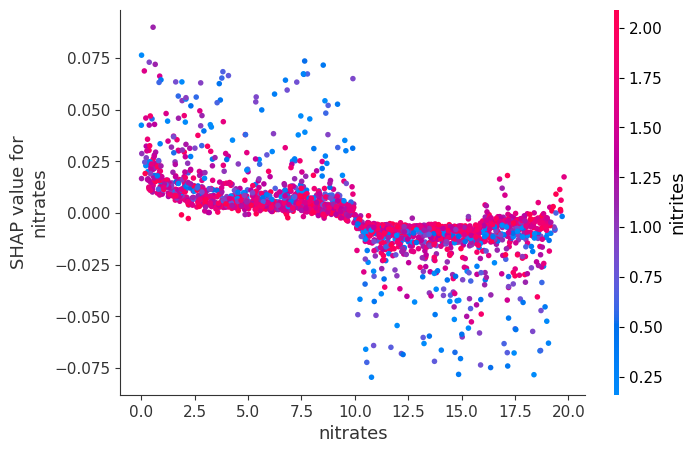

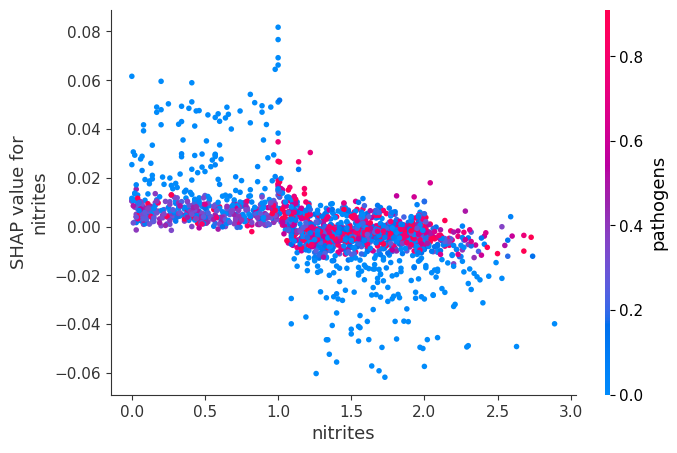

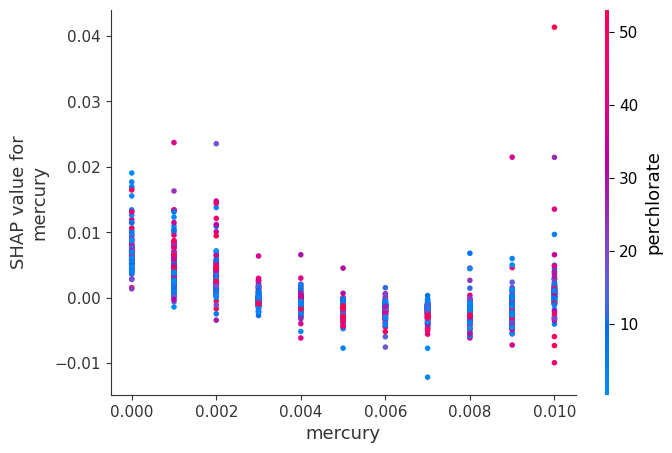

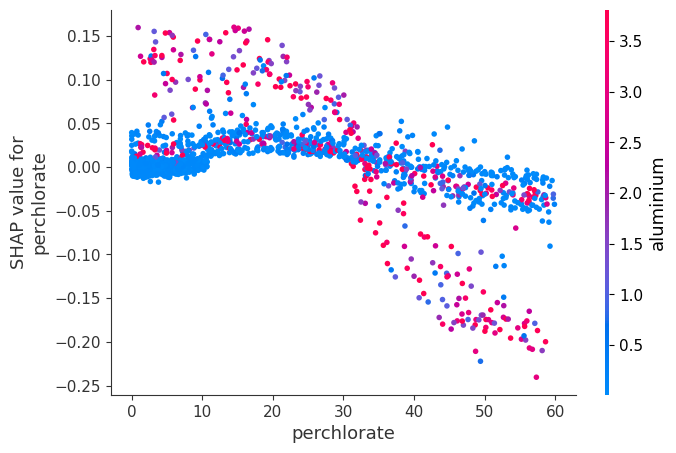

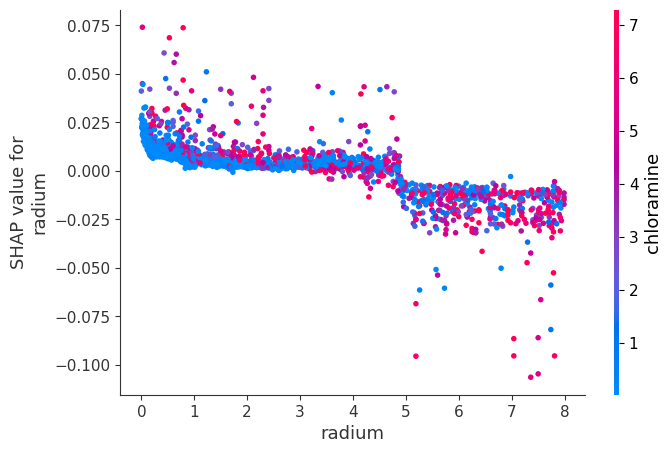

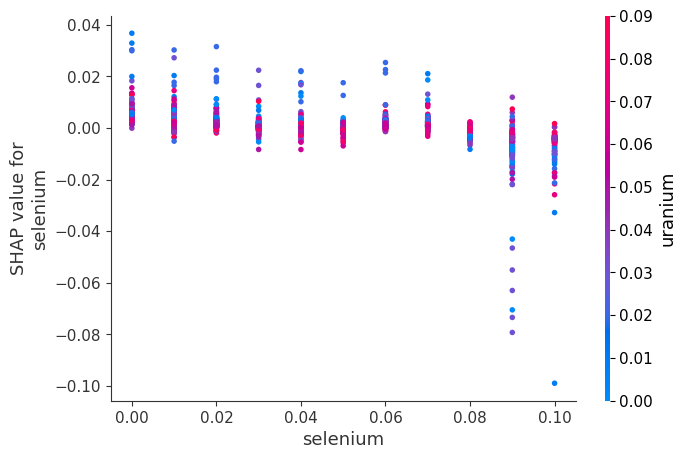

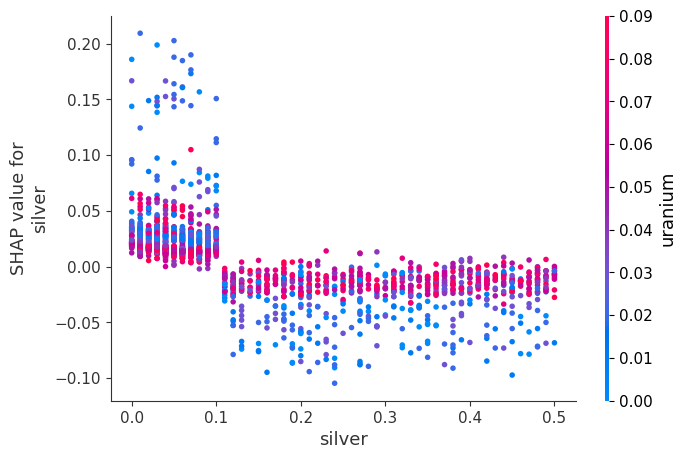

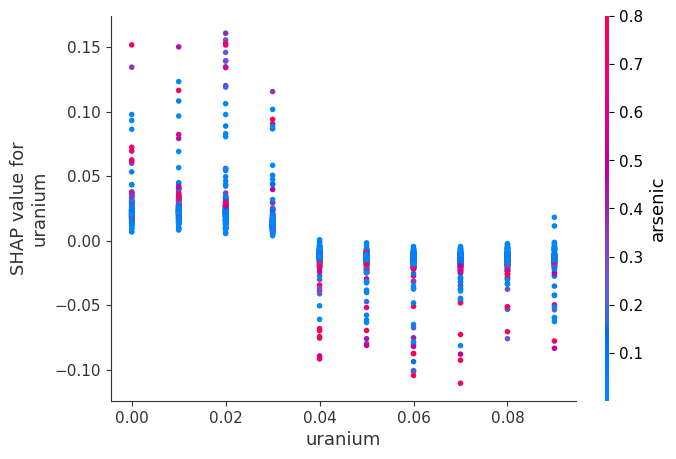

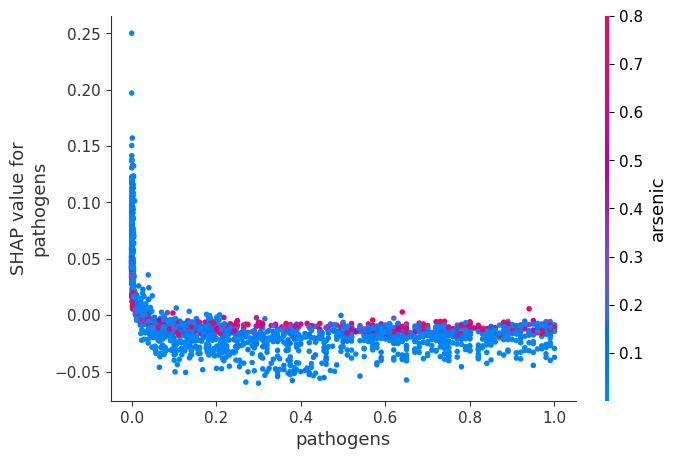

In [78]:
columns = X.columns
for col in columns:
    shap.dependence_plot(col, shap_values[1], X_test)

The dependence graphs of many of variables, such as arsenic, cadmium, nitrates, uranium or silver, clearly show from which value exactly the pollutants are dangerous. This proves that the model has been well trained.

The shap values for contaminants such as copper, fluoride, lead, nitrites, radium, selenium, barium or ammonia are concentrated around 0 in the dependence plots. This means that they do not have a high predictive power, which is confirmed by the already generated summary plot.

The dependance plots of aluminium and chloramine confirm the inverse relationship bewteen their values and the increase in water safety.


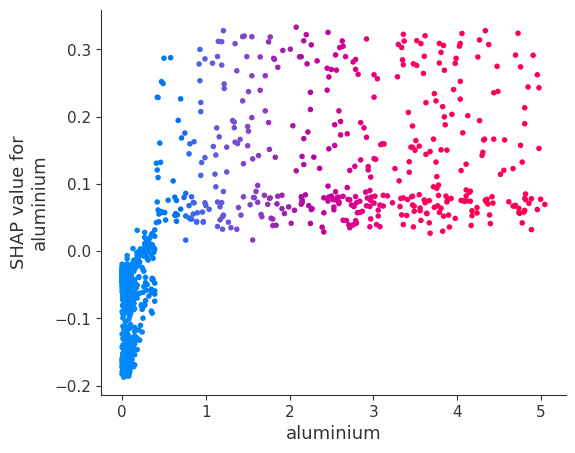

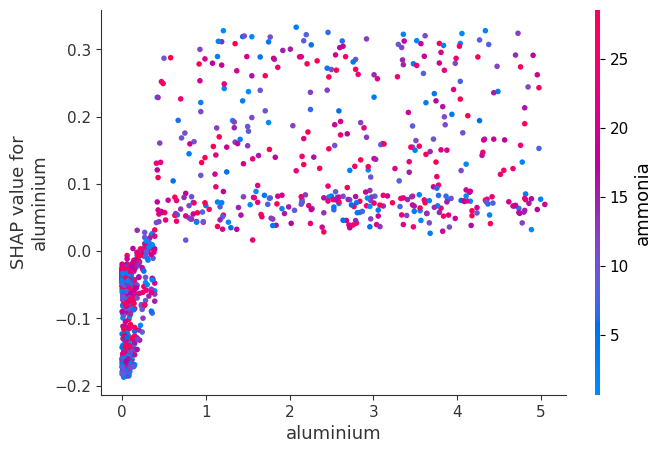

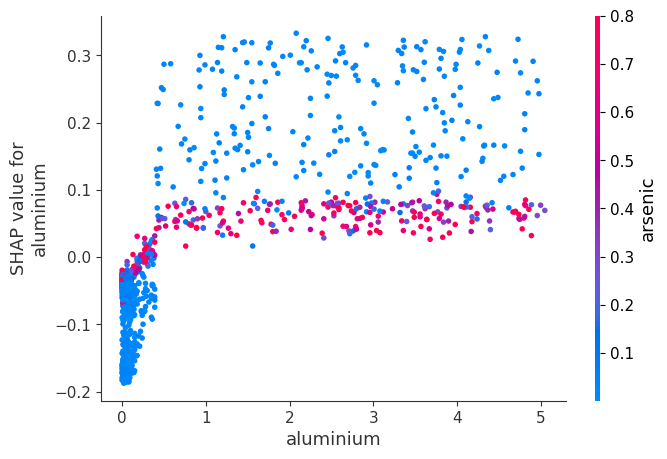

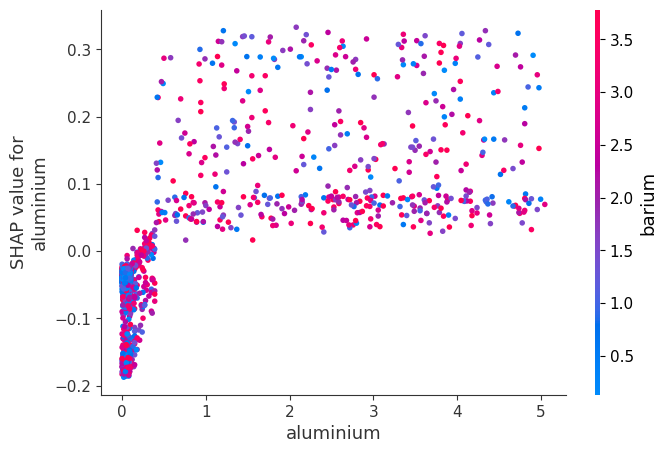

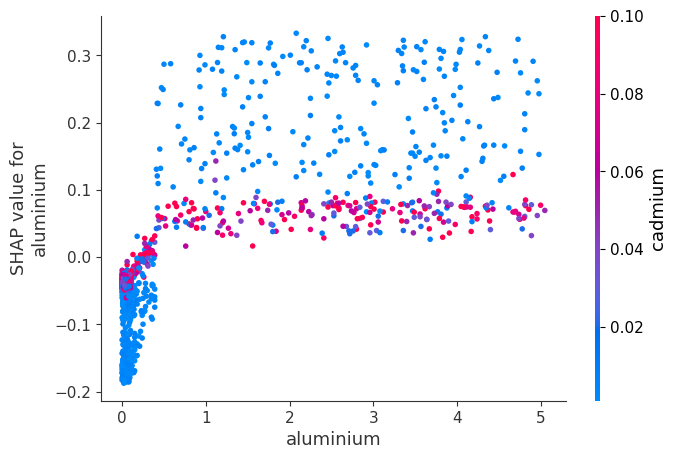

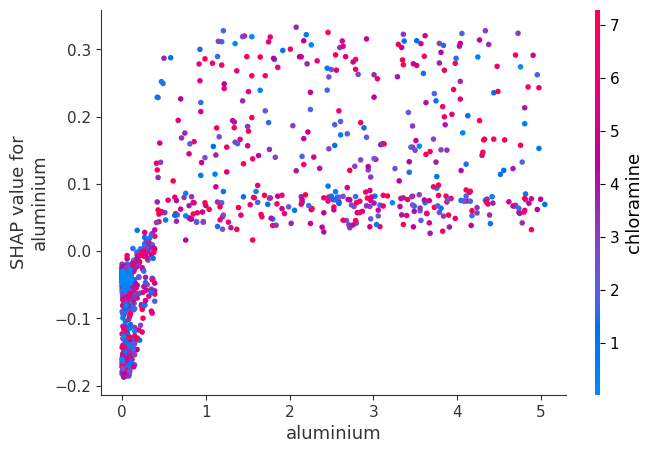

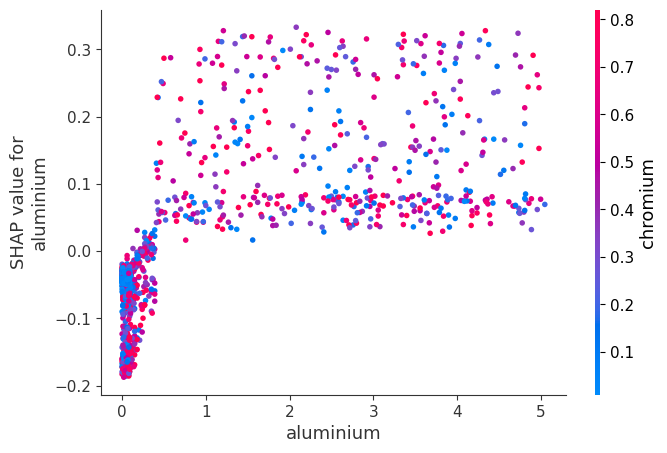

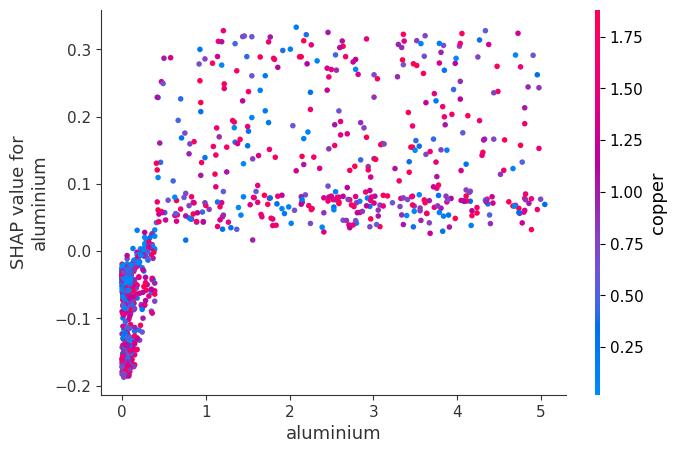

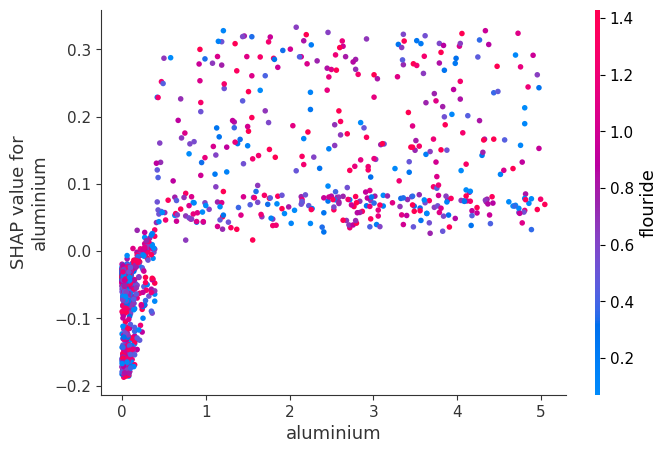

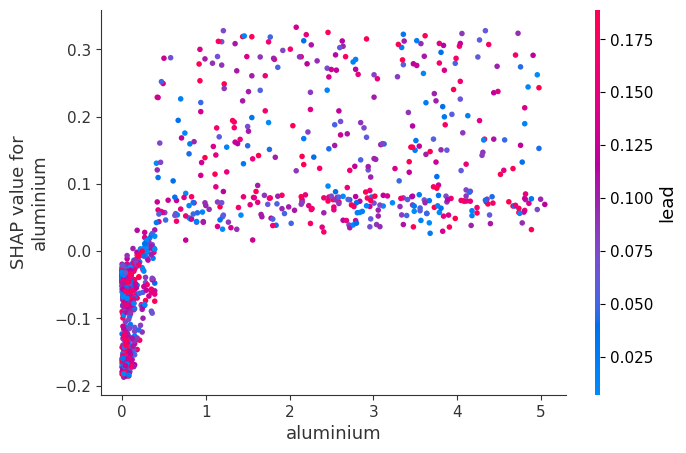

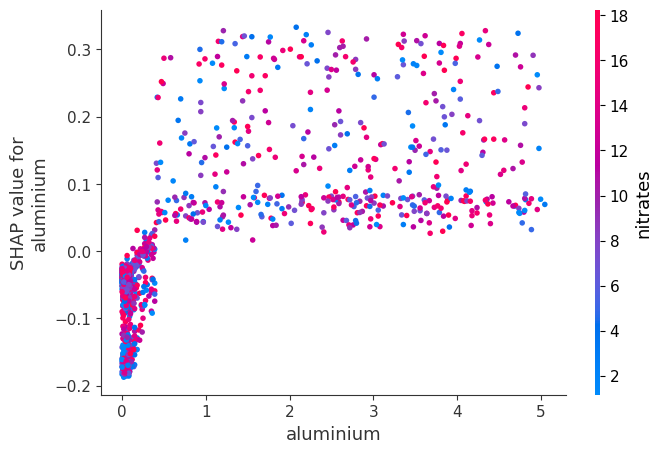

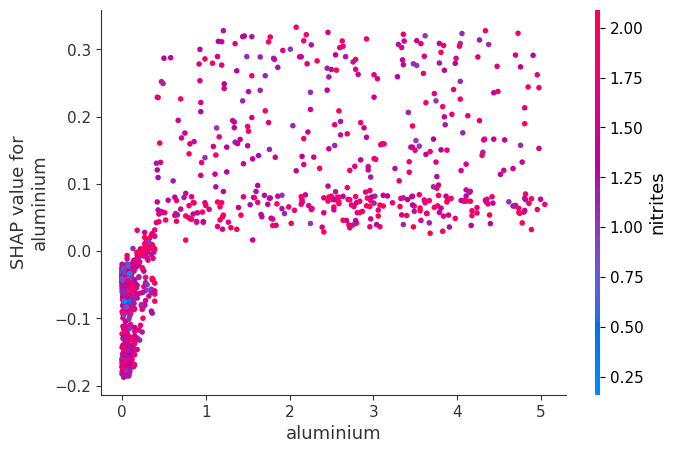

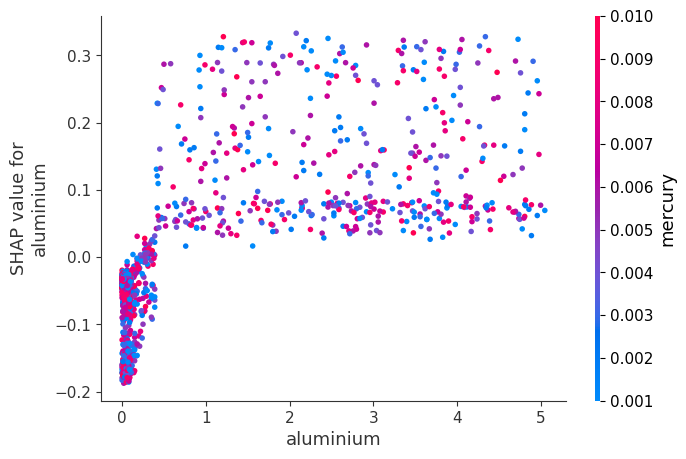

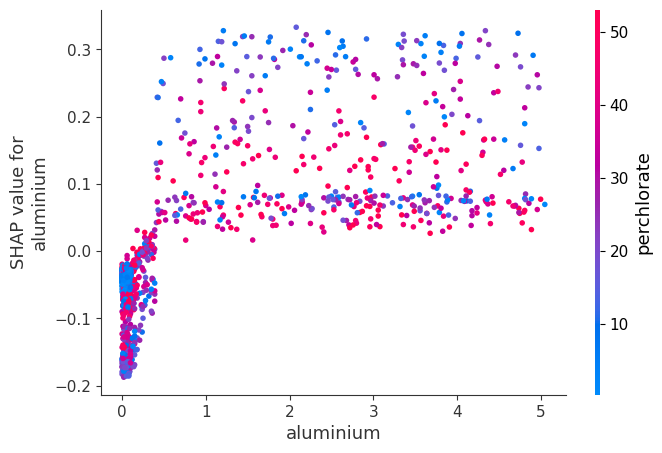

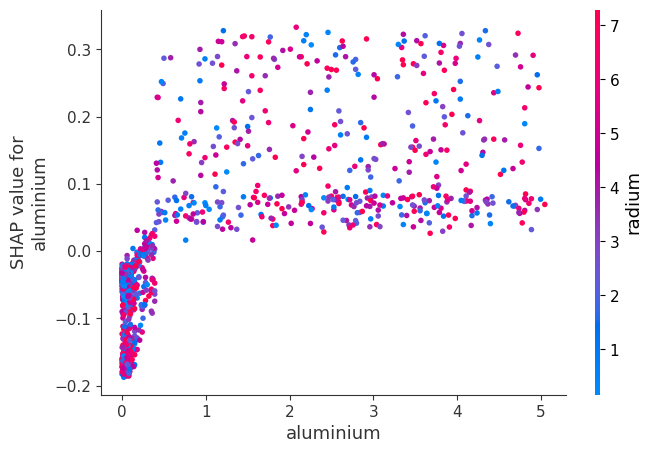

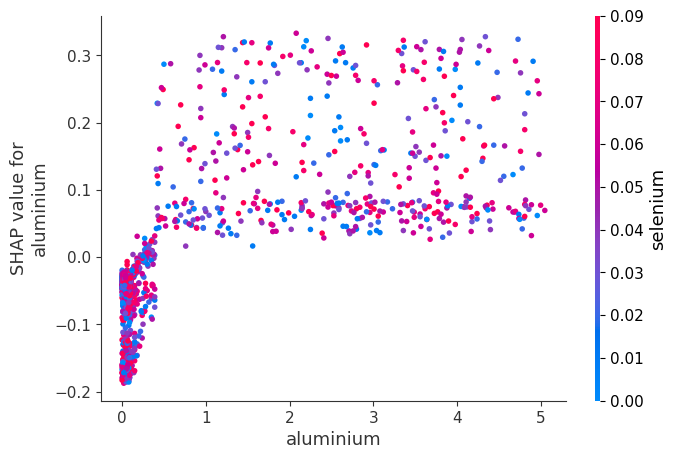

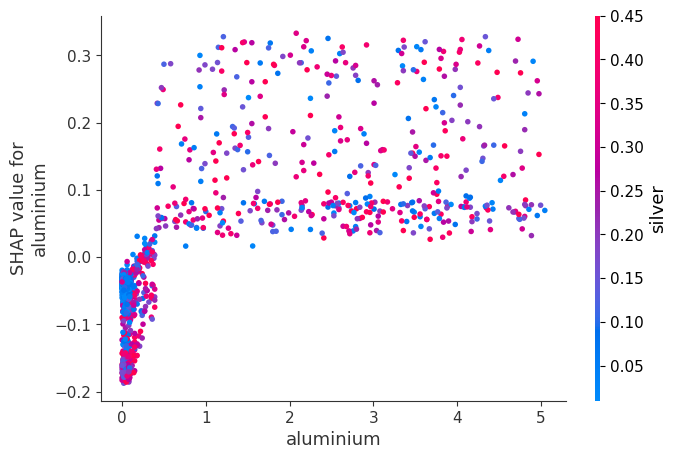

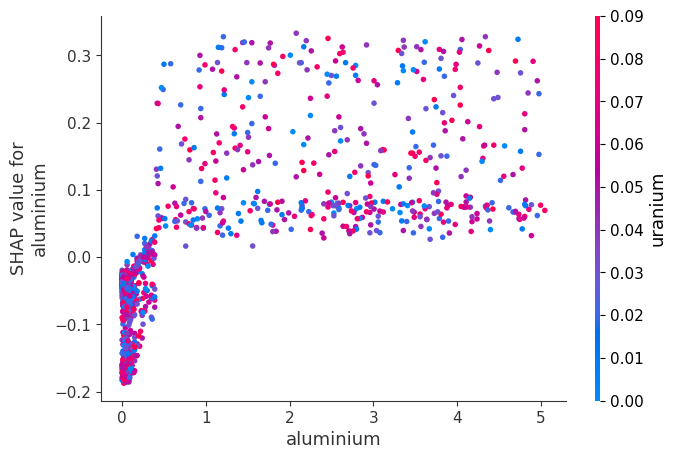

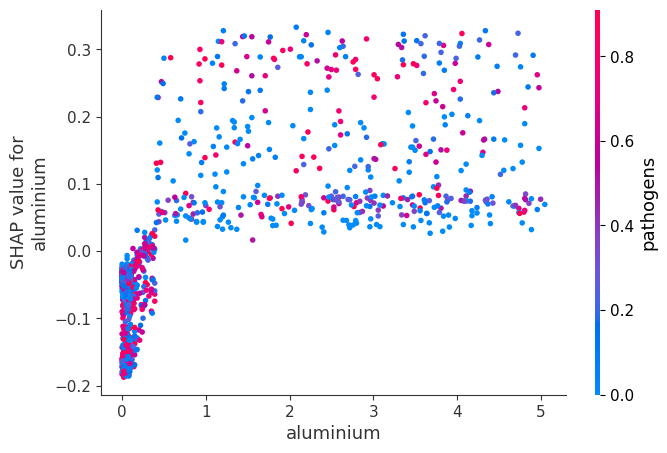

In [79]:
columns = X.columns
for col in columns:
    shap.dependence_plot("aluminium", shap_values[1], X_test, interaction_index=col)

In [80]:
X['aluminium'].mean()

0.6658218663997999

In [81]:
X['aluminium'].max()

5.05

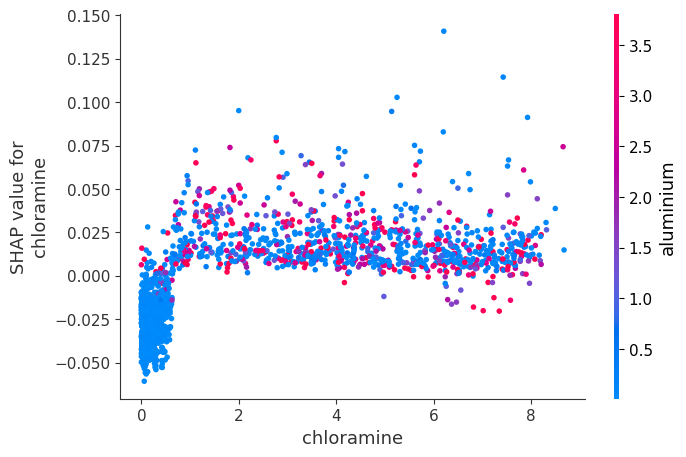

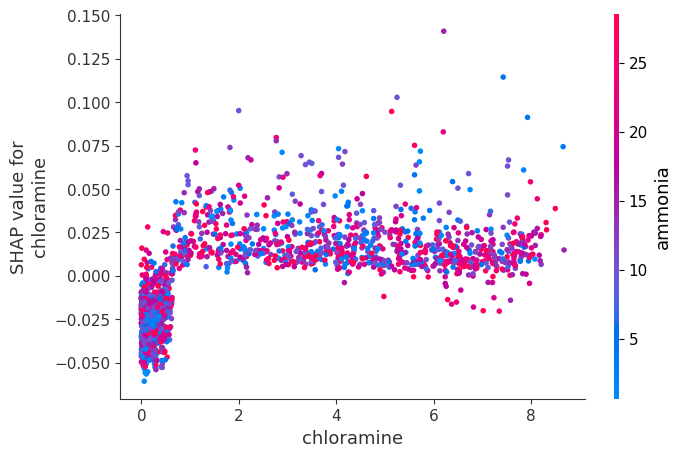

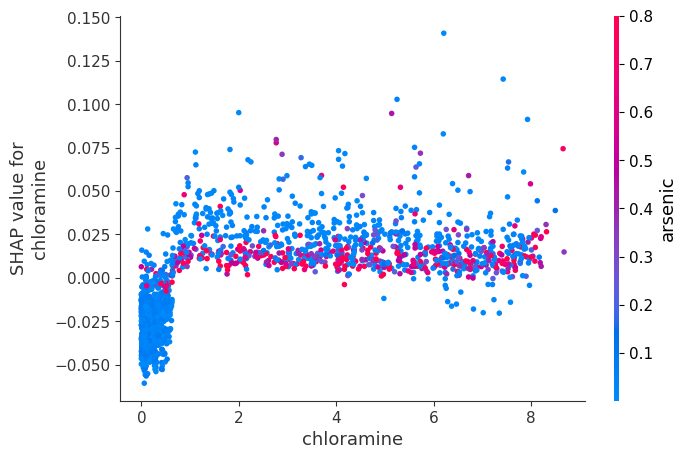

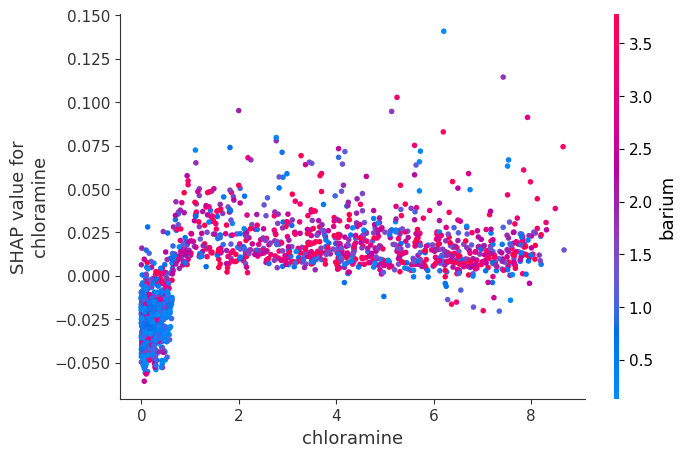

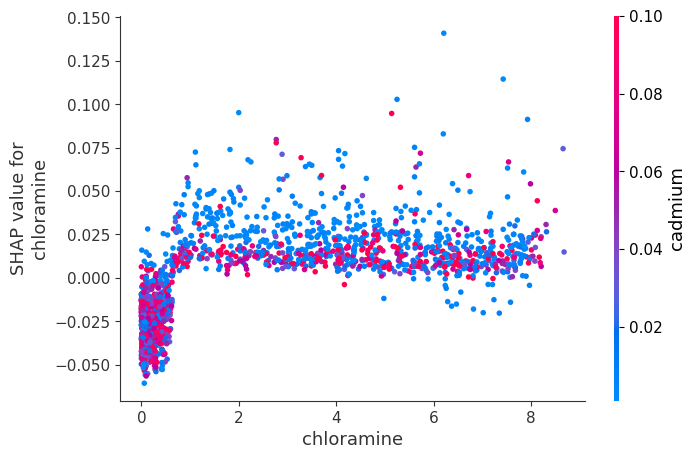

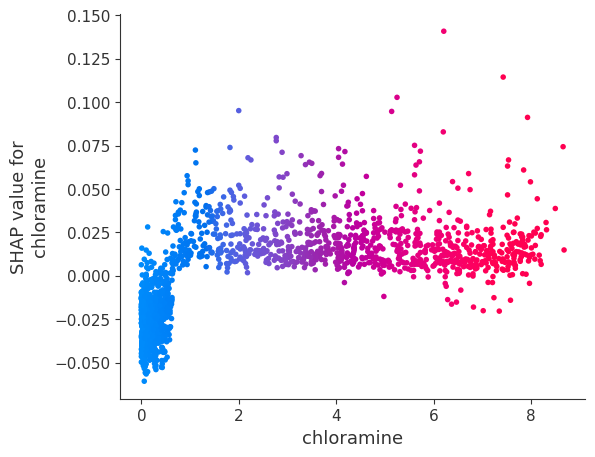

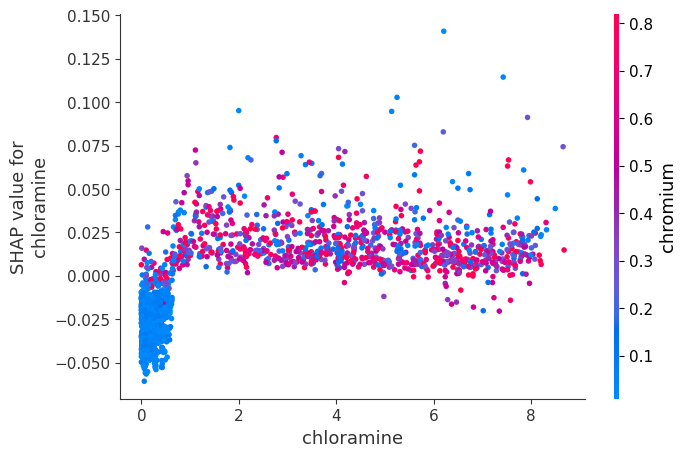

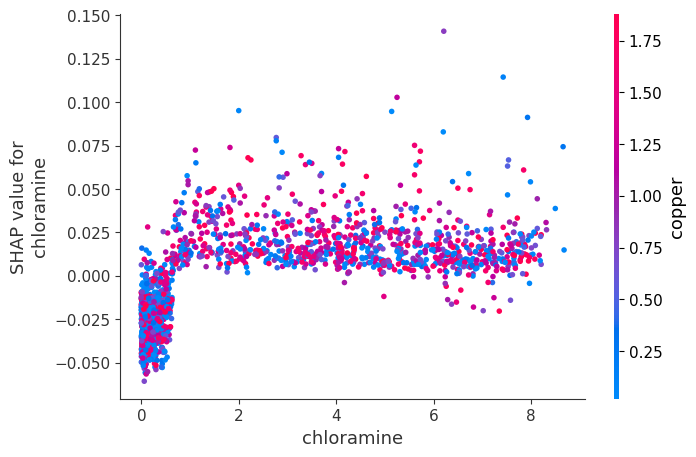

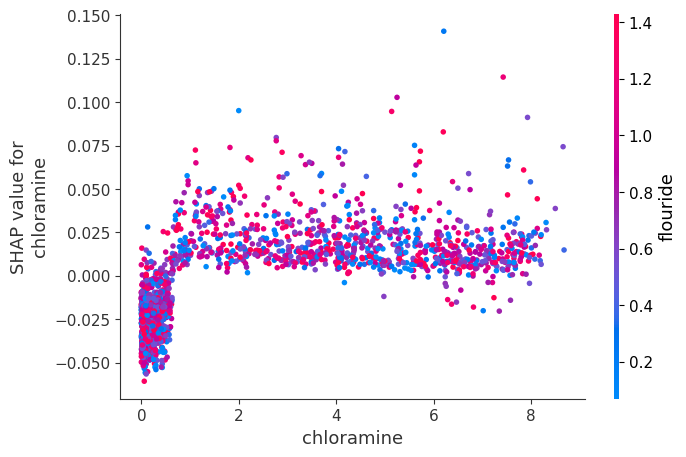

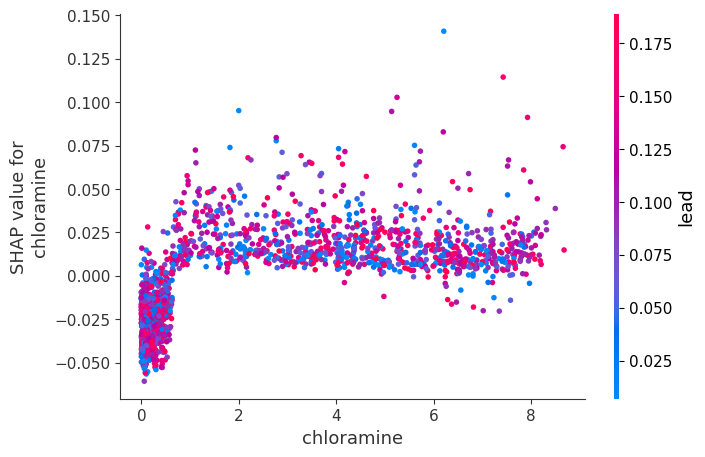

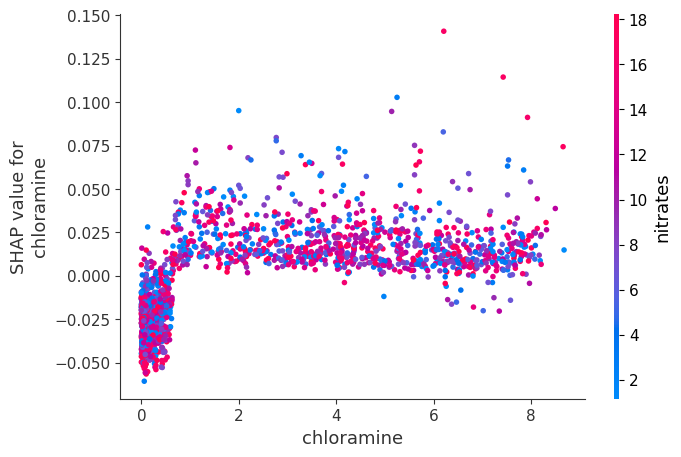

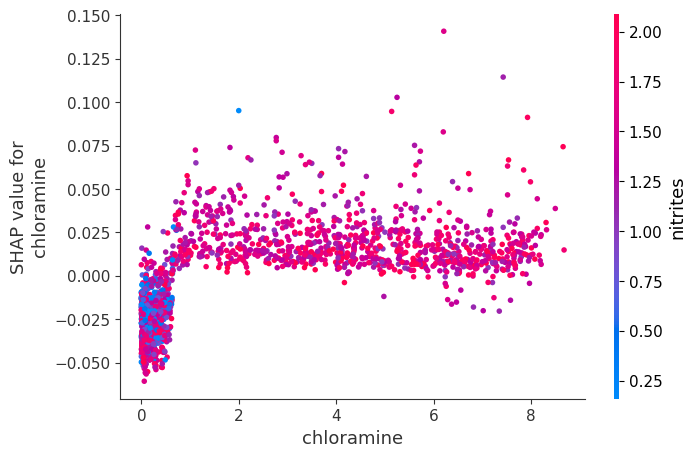

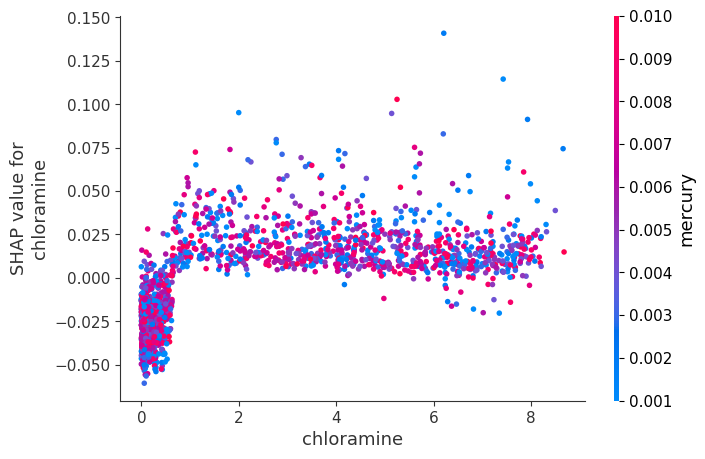

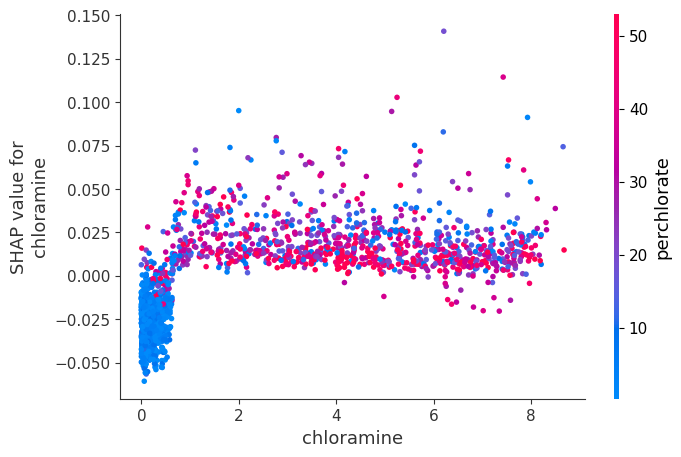

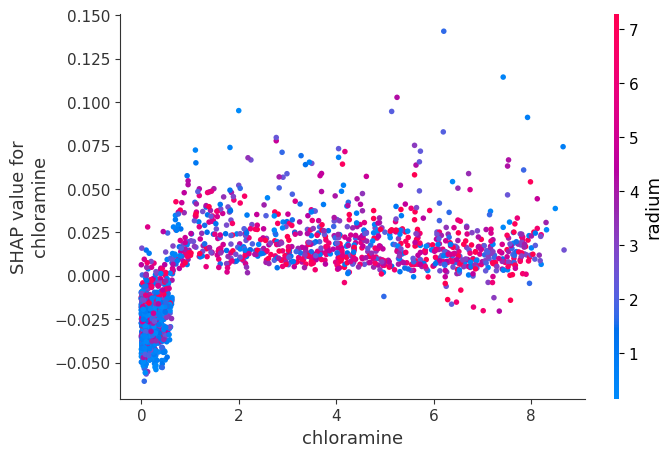

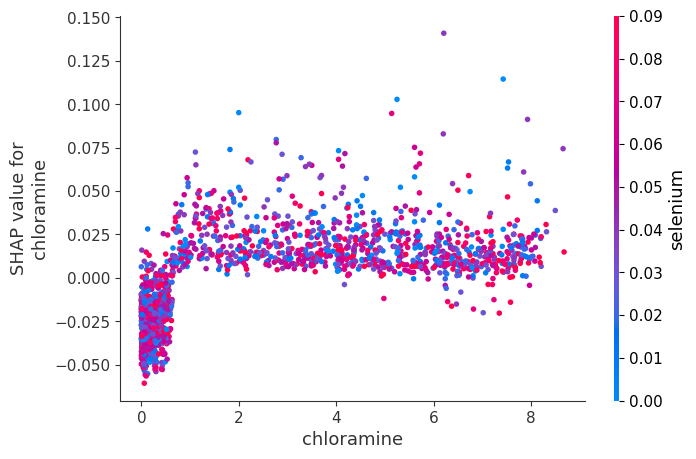

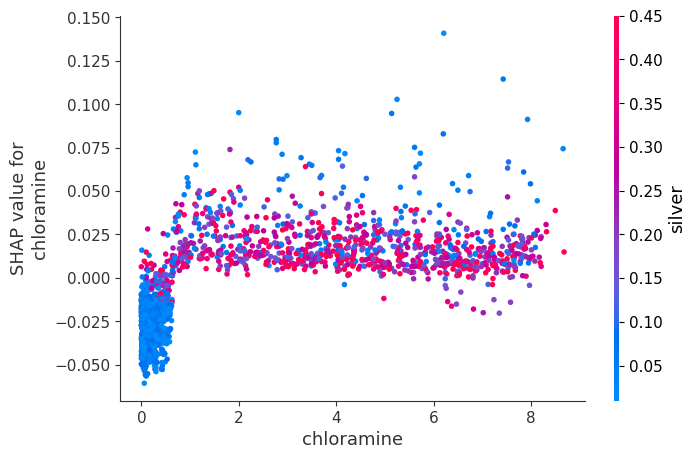

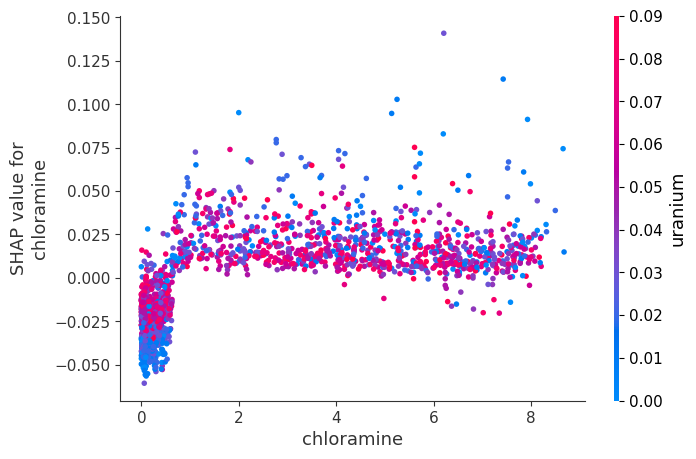

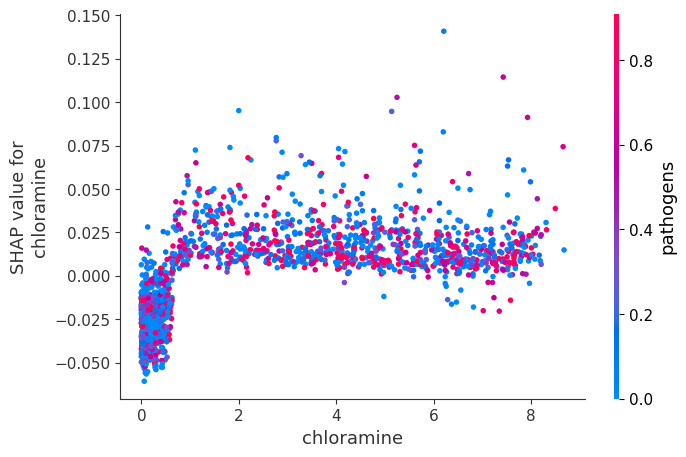

In [82]:
columns = X.columns
for col in columns:
    shap.dependence_plot("chloramine", shap_values[1], X_test, interaction_index=col)

In [83]:
X['chloramine'].mean()

2.1777220415311485

In [84]:
X['chloramine'].max()

8.68

After more detailed analysis of aluminium and chloramine variables can be concluded that there is no linear correlation between the contaminant and other elements. Probably, model found a relation that if aluminium or chloramine has low value, other contaminants have higer values. Hence, the inverse relationship. Aluminium has low mean value 0.7 and its maximum value equals 5.05. This contaminants becomes dangerous at 2.8. It can indicate that the majority of observations has low level of aluminium. Similarly, chloramine becomes dangerous at 4 and its mean value equals 2.2.


In [85]:
test = pd.concat([X_test, y_test], axis=1)
test.head()

aluminium  ammonia  arsenic  barium  cadmium  chloramine  chromium  \
2744       0.32    14.91     0.04    2.40    0.001        6.36      0.35   
3340       0.13    28.79     1.03    2.92    0.050        7.83      0.06   
1975       1.74     7.08     0.70    1.26    0.050        1.21      0.73   
2597       0.01    16.96     0.01    1.79    0.005        2.50      0.62   
4620       0.06     4.24     0.07    0.94    0.070        0.05      0.10   

      copper  flouride   lead  nitrates  nitrites  mercury  perchlorate  \
2744    1.48      0.54  0.126     11.21      1.22    0.007         9.56   
3340    0.66      0.03  0.024      2.40      1.57    0.010         7.70   
1975    1.78      0.33  0.061      2.16      1.39    0.010        46.50   
2597    0.79      0.15  0.106      6.94      1.09    0.001        19.33   
4620    0.00      0.99  0.165      4.00      0.50    0.005         6.74   

      radium  selenium  silver  uranium  pathogens  is_safe  
2744    7.90      0.02    0.17     0.06      0.730        0  
3340    5.82      0.02    0.17     0.03      0.620        0  
1975    4.79      0.01    0.24     0.02      0.110        0  
2597    4.62      0.02    0.41     0.07      0.620        0  
4620    0.79      0.02    0.03     0.06      0.001        0

In [90]:
c = X_test.loc[[3340]]

In [91]:
k_shap_values = explainer.shap_values(c)

In [92]:
shap.force_plot(explainer.expected_value[1], k_shap_values[1], c)

On the generated force plot can be observed that indeed chloramine, which is above its danger limit (4), increases safety of water and aluminium being significantly below its gander limit (2.8) decreases water safety.

Sometimes chloramine is used as a disinfectant to kill pathogenic germs. Perhaps this is why its slightly increased value makes the water safer.

In [93]:
train_ds = Dataset(X_train, label= y_train)
test_ds = Dataset(X_test, label=y_test)

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.


In [95]:
validation_suite = train_test_validation()
suite_result = validation_suite.run(train_ds, test_ds)
suite_result

Train Test Validation Suite: 
 
 
 
 3/12 [Time: 00:00, Check=New Category Train Test]

Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_20FC8R3TFG5GJJS85C675O4GJ">Train Test Validat…

According to Train Test Validation Suite there is not significant label or feature drift. The input data (X) and output data (y) do not shift in the test set compared to the values in the train set.